In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display
from scipy.stats import entropy

import BCI

pd.set_option('display.max_columns', None)

prefix = "./CyprusMetabarcoding/"
Acari_fasta_file = f"{prefix}/Acari_237ASVs_sequences_44locations.fasta"
Acari_OTUs = f"{prefix}/Acari_237ASVs_table_44locations.txt"
Coleo_fasta_file = f"{prefix}/Coleoptera_353ASVs_sequences_44locations.fasta"
Coleo_OTUs = f"{prefix}/Coleoptera_353ASVs_table_44locations.txt"
Collem_fasta_file = f"{prefix}/Collembola_317ASVs_sequences_44locations.fasta"
Collem_OTUs = f"{prefix}/Collembola_317ASVs_table_44locations.txt"

fasta_outdir = "./site_fastas/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load fasta data and asv tables

In [4]:
def load_fasta(infile):
    dat = open(infile).readlines()
    names = dat[::2]
    seqs = dat[1::2]
    # Remove leading '>' and trailing size info and newlines
    names = [x[1:].split(";")[0].strip() for x in names]
    seqs = [x.strip() for x in seqs]
    return pd.Series({x:y for x, y in zip(names, seqs)})
ac_fasta = load_fasta(Acari_fasta_file)
cp_fasta = load_fasta(Coleo_fasta_file)
cb_fasta = load_fasta(Collem_fasta_file)
all_fasta = pd.concat([ac_fasta, cp_fasta, cb_fasta])

## Load the ASV tables
ac_df = pd.read_csv(Acari_OTUs,
           sep="\t", index_col=0)
cp_df = pd.read_csv(Coleo_OTUs,
           sep="\t", index_col=0)
cb_df = pd.read_csv(Collem_OTUs,
           sep="\t", index_col=0)
all_df = pd.concat([ac_df, cp_df, cb_df])

### Dictionary mapping site codes to lists of sites

In [5]:
sites = ac_df.columns
site_codes = ["Cb", "Jn", "Pb", "Pn", "Qa"]
site_dict = {x:[y for y in sites if x in y] for x in site_codes}
print(site_dict)

{'Cb': ['Cb01PSI', 'Cb02TRI', 'Cb03TRI', 'Cb04TRI', 'Cb05TRI', 'Cb06TRI', 'Cb07STR'], 'Jn': ['Jn01CHI', 'Jn02CHI', 'Jn03CHI', 'Jn04CHI', 'Jn05TRO', 'Jn06CHI', 'Jn07AMI', 'Jn08CHI'], 'Pb': ['Pb01NWE', 'Pb02PSI', 'Pb03TRI', 'Pb04OIK', 'Pb05THE', 'Pb06SAI', 'Pb07LAG', 'Pb08MIT', 'Pb09KAP', 'Pb10LIT'], 'Pn': ['Pn01PRO', 'Pn02CHI', 'Pn03CHI', 'Pn04CHI', 'Pn05CHI', 'Pn06CHI', 'Pn07TRO', 'Pn08AMI'], 'Qa': ['Qa01NWE', 'Qa01TEST', 'Qa02PSI', 'Qa03TRI', 'Qa04STR', 'Qa05MIL', 'Qa06MAD', 'Qa07ALO', 'Qa08PAL', 'Qa09KIO', 'Qa10VAV']}


### Parse the fasta files and write one fasta per habitat type

In [6]:
## Merge Jn/Pn habitat or no?
for habitat in ["Cb", "Pb", "Qa", "Jn", "Pn"]:
    # Get ASVs that occur in at least one sample 
    asvs = all_df[all_df[site_dict[habitat]].any(axis=1)].index
    asvs = all_fasta[asvs]
    print(habitat, len(asvs))
    with open(f"{fasta_outdir}/{habitat}.fasta", 'w') as outfile:
        for k, v in asvs.items():
            outfile.write(f">{k}\n{v}\n")


Cb 201
Pb 325
Qa 315
Jn 174
Pn 160


In [7]:
fastas = glob.glob(f"{fasta_outdir}/*fasta")

bcis = {}
for fasta in fastas:
    site = fasta.split("/")[-1].split(".")[0]
    bcis[site] = BCI.BCI(data=fasta)
    bcis[site]._min_clust_threshold = 70
    bcis[site].run()
    print(site, bcis[site].bci)


Pb [325, 220, 190, 173, 169, 166, 160, 159, 156, 152, 152, 148, 143, 140, 136, 126, 120, 109, 102, 94, 76, 64, 54, 42, 37, 31, 25, 22, 18, 13]
Pn [159, 91, 84, 80, 78, 77, 77, 76, 76, 75, 74, 74, 74, 72, 68, 64, 58, 53, 48, 47, 41, 38, 30, 25, 22, 17, 14, 12, 8, 7]
Qa [315, 200, 169, 156, 146, 140, 136, 132, 131, 127, 125, 122, 120, 114, 110, 104, 96, 89, 85, 80, 68, 61, 49, 37, 30, 22, 20, 19, 10, 8]
Cb [201, 126, 104, 100, 97, 97, 96, 96, 96, 94, 92, 91, 86, 84, 77, 73, 67, 63, 59, 53, 49, 42, 35, 27, 20, 16, 15, 13, 12, 9]
Jn [174, 111, 97, 91, 90, 89, 88, 88, 87, 85, 83, 81, 81, 79, 71, 67, 66, 64, 61, 57, 52, 43, 35, 27, 21, 15, 14, 9, 7, 6]


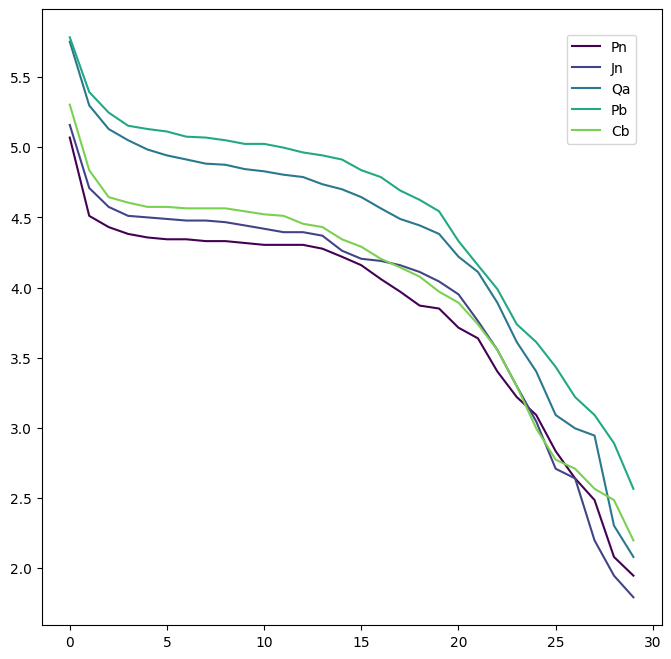

In [7]:
fig, ax = BCI.plot_multi(bcis.values(), log=True, normalize=False, cmap="viridis")
#plt.axvline(x=1)
#plt.axvline(x=3)
#ax.set_xticks(np.linspace(100, 81, 20))

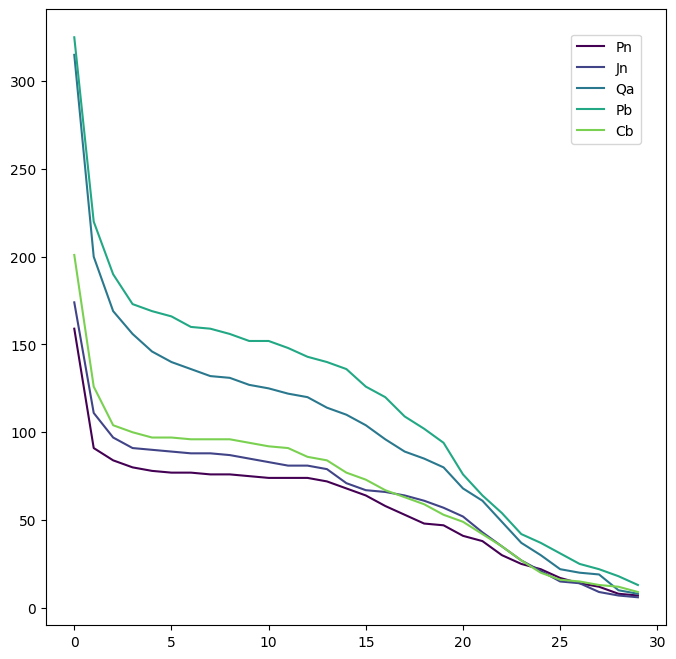

In [7]:
fig, ax = BCI.plot_multi(bcis.values(), log=False, normalize=False, cmap="viridis")
#ax.vlines(3, 3.5, 6)
#ax.set_xticks(np.linspace(100, 81, 20))

In [129]:
for bci in bcis.values():
    print(bci.samp, "\n", np.exp(entropy(bci.bci)))

Pn 
 25.395570818707203
Jn 
 25.064415158433945
Qa 
 24.29956335438495
Pb 
 24.84651346813895
Cb 
 24.88496082355356


In [133]:
t = bcis["Pn"].bci
np.exp(entropy(t/np.sum(t)))

25.395570818707203

In [9]:
def _generalized_hill_number(abunds, vals=None, order=1, scale=True, verbose=False):

    ## Degenerate edge cases can cause all zero values, particulary for pi
    ## in which case we bail out immediately
    if not np.any(abunds):
        return 0

    ## Be sure abundance is scaled to relative abundance and convert to np
    abunds = np.array(abunds)/np.sum(abunds)

    ## If vals is empty then populate the vector with a list of ones
    ## and this function collapses to the standard Hill number for abundance
    if vals is None:
        vals = np.ones(len(abunds))

    ## Make sure vals is an np array or else order > 2 will act crazy
    vals = np.array(vals)
    if verbose: print(("sums:", "dij", np.sum(vals), "pij", np.sum(abunds)))
    ## sum of values weighted by abundance
    V_bar = np.sum(vals*abunds)
    if verbose: print(("vbar", V_bar))

    ## Use the special formula for order = 1
    if order == 1:
        if np.any(abunds == 0):
            # If any values are 0 (legal values for pi) then log flips out
            # so fall back to the scipy.stats version
            h = np.exp(entropy(abunds))
        else:
            proportions = vals*(abunds/V_bar)
            h = np.exp(-np.sum(proportions * np.log(abunds/V_bar)))
    else:
        h = np.sum(vals*(abunds/V_bar)**order)**(1./(1-order))
    if scale: h = h/V_bar
    return h
_generalized_hill_number(bcis["Pn"].bci, order=2)

22.901171036417605

In [11]:
for bci in bcis.values():
    print("\n", bci.samp, end="\t")
    for idx in range(0, 5):
        print(_generalized_hill_number(bci.bci, order=idx), end='\t')
for bci in bcis.values():
    print("\n", bci.samp, "\t", bci.bci[3])



 Pn	30.0	25.395570818707203	22.901171036417605	21.038128228086865	19.40481561992461	
 Jn	30.0	25.064415158433945	22.74084401405683	21.071413339970654	19.609532636726012	
 Qa	30.0	24.29956335438495	21.310763447011713	19.076689554572166	17.230229041257903	
 Pb	30.000000000000004	24.846513468138966	22.23320655427422	20.423607378087976	18.92425163859763	
 Cb	30.0	24.88496082355356	22.173996913580243	20.214270593109436	18.55532284715452	
 Pn 	 80

 Jn 	 91

 Qa 	 156

 Pb 	 173

 Cb 	 100
